# Graphs and Dataframes

## Datasets

In [1]:
import numpy as np
from pathlib import Path
import networkx as nx
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')

def find_neighbors(G, node):
    successors = set(G.successors(node))
    predecessors = set(G.predecessors(node))
    neighbors = successors | predecessors
    return len(neighbors)

def read_net_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    nodes = {}
    n_states = 0
    create = True
    
    for line in lines:
        if line.strip() and not line.startswith('*'):  # Ignora le righe vuote e i commenti
            parts = line.strip().split()
            if len(parts) == 5:
                nodes[int(parts[0])-1] = [parts[1].replace('"', ''), float(parts[2]), float(parts[3])]
                n_states += 1
            elif len(parts) == 3:
                if create:
                    matrix = [[0 for _ in range(n_states)] for _ in range(n_states)]
                    create = False
                matrix[int(parts[0])-1][int(parts[1])-1] = float(parts[2])

    return nodes, matrix

In [2]:
dataset_folder = Path.cwd().joinpath("datasets")
data2005 = dataset_folder.joinpath("2005.net")

nodes, m2010 = read_net_file(data2005)

In [3]:
G2010 = nx.DiGraph()

for r in range(len(m2010)):
  for c in range(len(m2010[r])):
    if m2010[r][c]>0:
      G2010.add_edge(nodes[r][0], nodes[c][0], price=m2010[r][c])

print(G2010)

DiGraph with 161 nodes and 17201 edges


## Binary graph

In [4]:
Tot2010 = {'Imp':[sum(i) for i in m2010], 'Exp':[sum([m2010[j][i] for j in range(len(m2010))]) for i in range(len(m2010))], 'ImpPartners':[sum(1 for e in i if e > 0) for i in m2010], 'ExpPartners':[sum([1 for j in range(len(m2010)) if m2010[j][i] > 0]) for i in range(len(m2010))]}

threshold = 0.1

G2010bin = nx.DiGraph()


for r in range(len(m2010)):
  for c in range(len(m2010[r])):
    if (m2010[r][c]>0) and ((m2010[r][c]>threshold*Tot2010['Imp'][r])) and ((m2010[r][c]>threshold*Tot2010['Exp'][c])):
      G2010bin.add_edge(nodes[r][0], nodes[c][0], importance='both', price=m2010[r][c])
    elif (m2010[r][c]>0) and ((m2010[r][c]>threshold*Tot2010['Imp'][r])):
      G2010bin.add_edge(nodes[r][0], nodes[c][0], importance='import', price=m2010[r][c])
    elif (m2010[r][c]>0) and ((m2010[r][c]>threshold*Tot2010['Exp'][c])):
      G2010bin.add_edge(nodes[r][0], nodes[c][0], importance='export', price=m2010[r][c])

print(G2010bin)

DiGraph with 161 nodes and 609 edges


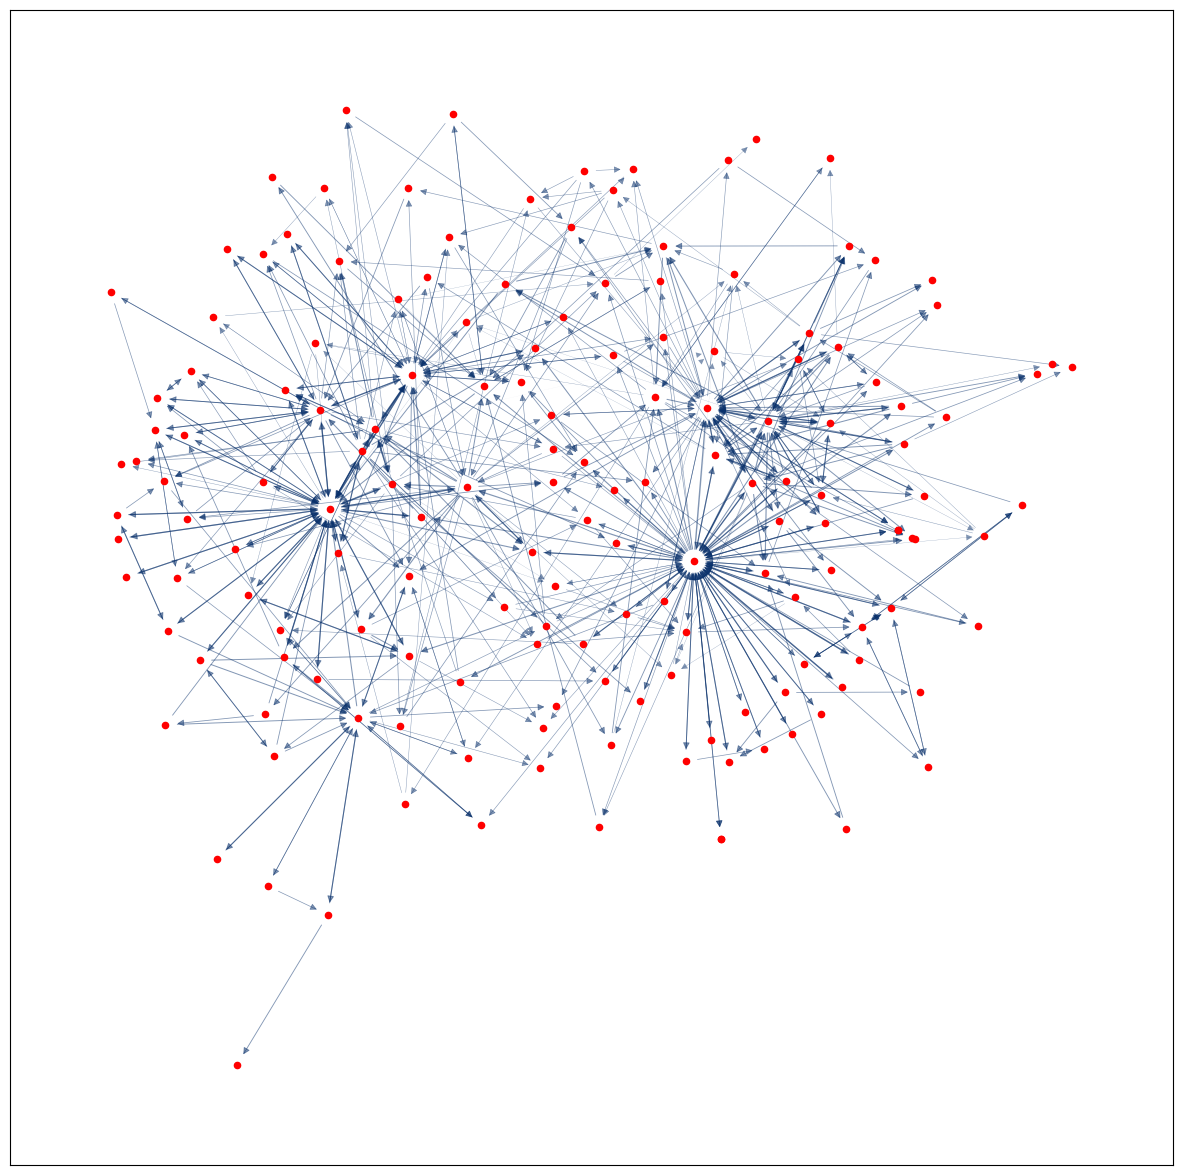

In [5]:
prices = nx.get_edge_attributes(G2010bin, 'price').values()
prices = [math.log(i) for i in list(prices)]
max_price = max(prices)
min_price = min(prices)
norm_prices = [(price - min_price) / (max_price - min_price) for price in prices]

edges = G2010bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]

# draw the graph
pos = nx.kamada_kawai_layout(G2010bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2010bin, pos, node_size=20, node_color='red', label=True)
#nx.draw_networkx_edges(G2010lite, pos, alpha=0.5)
nx.draw_networkx_edges(G2010bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)

plt.savefig("network2010.png")
plt.show()

In [6]:
G2010.edges.data('price')

OutEdgeDataView([('ALB', 'ARE', 1240.77), ('ALB', 'ARG', 2169.89), ('ALB', 'AUS', 896.984), ('ALB', 'AUT', 44350.5), ('ALB', 'AZE', 2289.66), ('ALB', 'BEL', 19719.0), ('ALB', 'BGD', 0.769), ('ALB', 'BGR', 72907.4), ('ALB', 'BHR', 21.961), ('ALB', 'BIH', 3329.8), ('ALB', 'BLR', 6742.75), ('ALB', 'BRA', 23056.0), ('ALB', 'BRB', 9.863), ('ALB', 'CAN', 5019.22), ('ALB', 'CHE', 18256.0), ('ALB', 'CHL', 125.588), ('ALB', 'CHN', 168401.0), ('ALB', 'CIV', 0.909), ('ALB', 'CMR', 29.075), ('ALB', 'COL', 2053.34), ('ALB', 'COM', 31.321), ('ALB', 'CRI', 507.844), ('ALB', 'CYP', 4170.59), ('ALB', 'CZE', 17936.4), ('ALB', 'DEU', 132743.0), ('ALB', 'DMA', 18.29), ('ALB', 'DNK', 6183.97), ('ALB', 'DZA', 140.379), ('ALB', 'ECU', 7874.58), ('ALB', 'EGY', 11229.2), ('ALB', 'ESP', 44071.9), ('ALB', 'EST', 189.529), ('ALB', 'ETH', 11.92), ('ALB', 'FIN', 14028.3), ('ALB', 'FRA', 30892.6), ('ALB', 'GAB', 16.573), ('ALB', 'GBR', 21991.6), ('ALB', 'GEO', 8963.8), ('ALB', 'GHA', 49.803), ('ALB', 'GIN', 5.749), 

## Df creation

In [7]:
gdp_df = pd.read_csv('datasets/GDP.csv')
gdp2010 = gdp_df[gdp_df['Year']==2010][['Code', 'GDP (constant 2015 US$)']]

node_in =  pd.DataFrame.from_dict(dict(G2010.in_degree()),orient="index", columns=['Imp Deg']).reset_index()
node_out =  pd.DataFrame.from_dict(dict(G2010.out_degree()),orient="index", columns=['Exp Deg']).reset_index()
df_2010 = pd.merge(node_in, node_out, on='index')
df_2010 = df_2010.sort_values(by='index')
df_2010.reset_index(drop=True, inplace=True)
df_2010['Tot Deg'] = df_2010['Imp Deg'] + df_2010['Exp Deg']
df_2010['Import'] = Tot2010['Imp']
df_2010['Export'] = Tot2010['Exp']
df_2010['Tot Partners'] = [find_neighbors(G2010, i) for i in df_2010['index']]
df_2010['GDP'] = [np.NaN for _ in range(len(df_2010))]
for id in df_2010['index']:
    try:
        df_2010.loc[df_2010['index'] == id, 'GDP'] = gdp2010.loc[gdp2010['Code'] == id, 'GDP (constant 2015 US$)'].iloc[0]
    except:
        continue


df_2010

index  Imp Deg  Exp Deg  Tot Deg        Import        Export  \
0     AGO       85        0       85  0.000000e+00  2.101176e+07   
1     ALB       94      113      207  2.468323e+06  6.358189e+05   
2     ARE      133      142      275  5.998854e+07  7.970136e+07   
3     ARG      135      123      258  2.843278e+07  4.260389e+07   
4     ARM       76       93      169  1.563535e+06  7.869679e+05   
..    ...      ...      ...      ...           ...           ...   
156   VNM      135      138      273  3.166304e+07  3.389133e+07   
157   YEM       83      120      203  4.933262e+06  5.376410e+06   
158   ZAF      136      160      296  5.334689e+07  5.507576e+07   
159   ZMB       90      104      194  2.502708e+06  2.466188e+06   
160   ZWE      107      114      221  1.983931e+06  1.937457e+06   

     Tot Partners           GDP  
0              85  7.255630e+10  
1             126  1.042021e+10  
2             151  2.929686e+11  
3             145  5.527382e+11  
4             105  8.513509e+09  
..            ...           ...  
156           153  1.773225e+11  
157           127  6.303868e+10  
158           160  3.116536e+11  
159           119  1.652712e+10  
160           134  1.408312e+10  

[161 rows x 8 columns]

In [8]:
param = 'Import' # Choose between the df columns

percentile_99 = np.percentile(df_2010[param], 98)
hub_nodi = df_2010[df_2010[param] >= percentile_99]['index'].tolist()
print('Nodes hub 2010: ', hub_nodi)

Nodes hub 2010:  ['CHN', 'DEU', 'GBR', 'USA']


# Analysis on the binary graph

## Density

In [9]:
density = round(nx.density(G2010bin),3)
densityTot = round(nx.density(G2010),3)
print('2010 | Total density: {} | over 10%: {}'.format(densityTot, density))

2010 | Total density: 0.668 | over 10%: 0.024


## Degree

Standard deviation: 12.212295305541858
Mean: 7.565217391304348
Median: 5.0
Min: 1
Max: 114
Assortativity coefficient: -0.3659778165595966


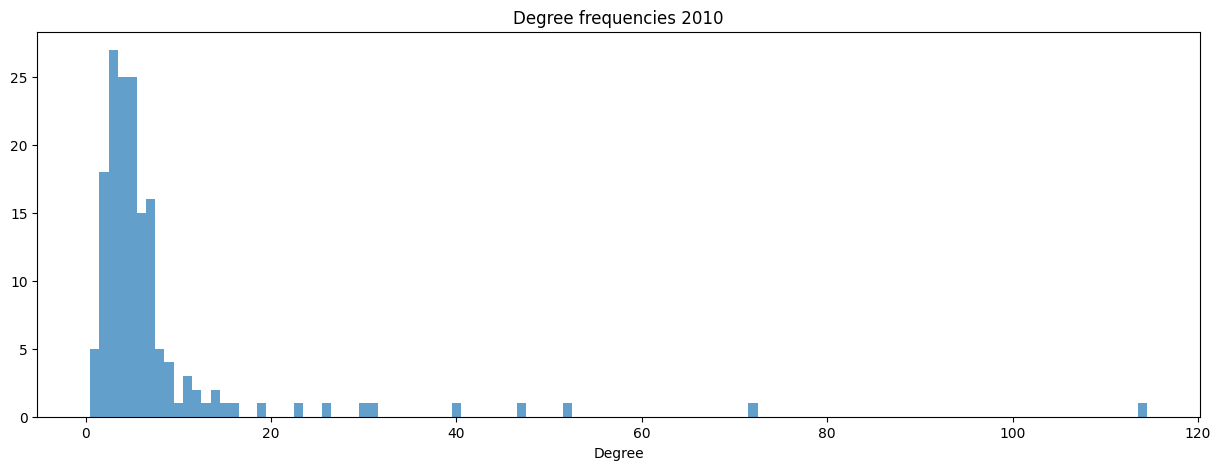

In [10]:
degree = list(dict(G2010bin.degree()).values())
print('Standard deviation: {}'.format(np.std(degree)))
print('Mean: {}'.format(np.mean(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))
print("Assortativity coefficient: " + str(nx.degree_assortativity_coefficient(G2010bin)))

plt.figure(figsize=(15,5))
plt.hist(degree, bins=np.arange(min(degree), max(degree) + 2) - 0.5, alpha=0.7)
plt.xlabel('Degree')
plt.title('Degree frequencies 2010')
plt.savefig('DegreeFreq2010')
plt.show()


In [11]:
print(dict(G2010bin.degree()))

{'ALB': 3, 'GRC': 9, 'ITA': 30, 'ARE': 11, 'CHN': 52, 'IND': 14, 'LBN': 3, 'ARG': 11, 'BOL': 6, 'BRA': 12, 'PRY': 5, 'URY': 5, 'USA': 114, 'ARM': 7, 'BEL': 23, 'RUS': 26, 'ATG': 4, 'TTO': 10, 'AUS': 12, 'FJI': 8, 'JPN': 40, 'NZL': 9, 'PNG': 3, 'AUT': 2, 'DEU': 72, 'AZE': 5, 'BDI': 4, 'KEN': 7, 'CAF': 4, 'FRA': 47, 'IRL': 6, 'KIR': 7, 'LBR': 3, 'LSO': 2, 'LUX': 8, 'MOZ': 7, 'NLD': 13, 'SLE': 2, 'UGA': 4, 'BEN': 5, 'BFA': 5, 'CIV': 8, 'TGO': 5, 'BGD': 6, 'BGR': 5, 'BHR': 4, 'BHS': 4, 'BIH': 7, 'HRV': 7, 'BLR': 2, 'BRB': 5, 'BTN': 3, 'BWA': 2, 'ZAF': 14, 'CMR': 6, 'CAN': 3, 'JAM': 6, 'CHE': 6, 'CHL': 7, 'AGO': 2, 'COG': 2, 'ETH': 4, 'GNQ': 3, 'HKG': 9, 'IRN': 4, 'KAZ': 8, 'KGZ': 5, 'KOR': 16, 'MAC': 6, 'MLI': 7, 'MNG': 4, 'MYS': 7, 'OMN': 6, 'PER': 3, 'PHL': 5, 'SGP': 15, 'THA': 11, 'TZA': 3, 'UZB': 2, 'YEM': 2, 'ZMB': 5, 'NGA': 5, 'COL': 4, 'COM': 7, 'CRI': 3, 'CYP': 5, 'CZE': 5, 'SVK': 5, 'DNK': 5, 'ESP': 19, 'FIN': 6, 'GBR': 31, 'GRD': 5, 'HUN': 2, 'ISL': 3, 'MKD': 6, 'NOR': 6, 'POL': 

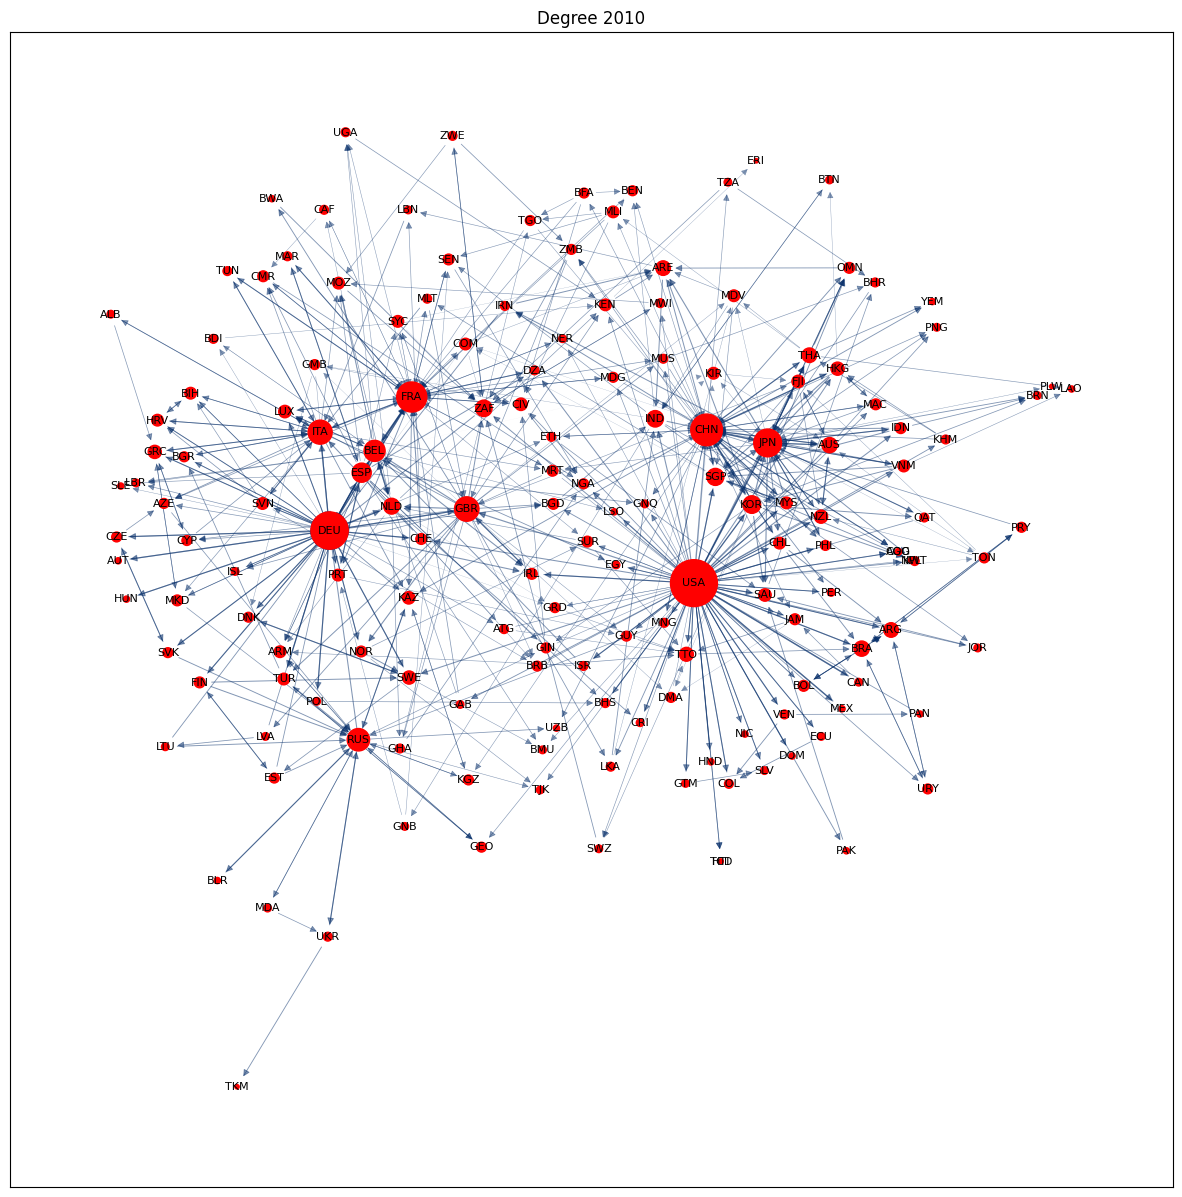

In [12]:
edges = G2010bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [v*10 for v in degree]

# draw the graph
pos = nx.kamada_kawai_layout(G2010bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2010bin, pos, node_size=node_size, node_color='red', label=True)
nx.draw_networkx_edges(G2010bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2010bin, pos, font_size = 8)

plt.title('Degree 2010')

plt.savefig("Degree2010.png")
plt.show()

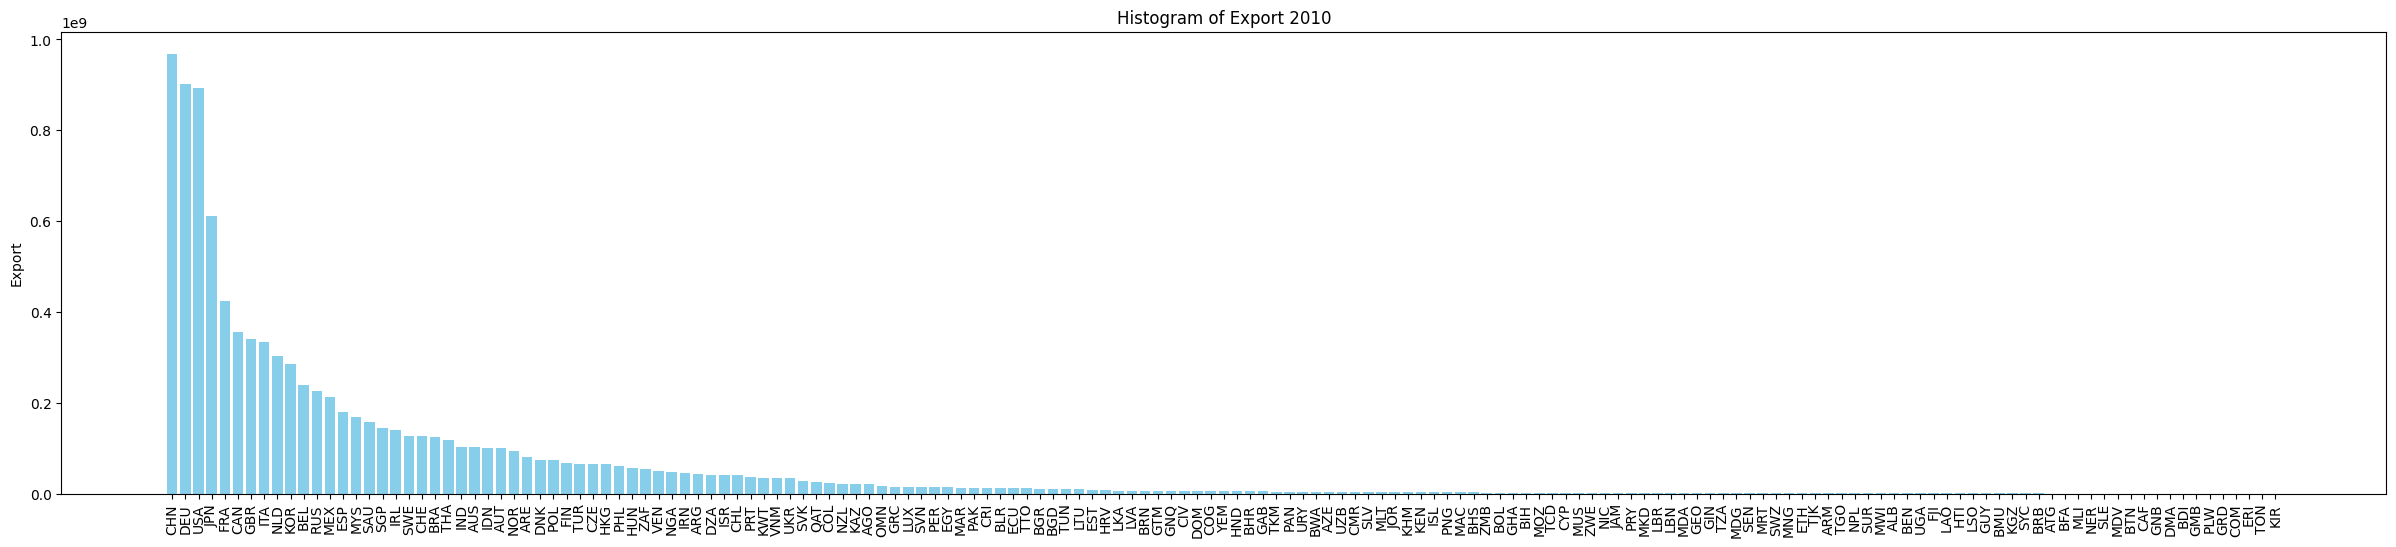

In [13]:
plot = 'Export'
plt.figure(figsize=(30, 6))
plt.bar(df_2010.sort_values(by=plot, ascending=False)['index'], df_2010.sort_values(by=plot, ascending=False)[plot], color='skyblue')
plt.ylabel(plot)
plt.title('Histogram of '+plot+' 2010')
plt.xticks(rotation=90)
plt.savefig(plot+"2010.png")
plt.show()


In [14]:
print(list(nx.isolates(G2010)))

[]


## Clustering

In [15]:
clusters = nx.average_clustering(G2010bin, weight='wheight') #weight='price'
clusters

0.38235395760608926

In [16]:
local_cluster = nx.clustering(G2010bin, weight='weight')
sorted(local_cluster.items(), key=lambda item: item[1], reverse= True)


[('ALB', 1.0),
 ('BOL', 1.0),
 ('URY', 1.0),
 ('PNG', 1.0),
 ('SLE', 1.0),
 ('CAN', 1.0),
 ('YEM', 1.0),
 ('ISL', 1.0),
 ('ECU', 1.0),
 ('MAR', 1.0),
 ('TUN', 1.0),
 ('GTM', 1.0),
 ('SLV', 1.0),
 ('MDA', 1.0),
 ('PAK', 1.0),
 ('PAN', 1.0),
 ('BIH', 0.9444444444444444),
 ('HRV', 0.9444444444444444),
 ('PHL', 0.875),
 ('MYS', 0.8333333333333334),
 ('CAF', 0.8),
 ('COL', 0.8),
 ('QAT', 0.8),
 ('MAC', 0.7692307692307693),
 ('LUX', 0.76),
 ('BGR', 0.75),
 ('TON', 0.75),
 ('MKD', 0.6923076923076923),
 ('SVN', 0.6842105263157895),
 ('LBR', 0.6666666666666666),
 ('CYP', 0.6666666666666666),
 ('KWT', 0.6666666666666666),
 ('NZL', 0.6515151515151515),
 ('OMN', 0.6428571428571429),
 ('KGZ', 0.625),
 ('CZE', 0.625),
 ('SVK', 0.625),
 ('DNK', 0.625),
 ('EST', 0.6111111111111112),
 ('IDN', 0.6071428571428571),
 ('VEN', 0.6),
 ('KHM', 0.5833333333333334),
 ('CHL', 0.5789473684210527),
 ('FIN', 0.5384615384615384),
 ('VNM', 0.525),
 ('GRC', 0.5),
 ('ARG', 0.5),
 ('PRY', 0.5),
 ('BWA', 0.5),
 ('AGO', 0

## Centrality

In [17]:
import statistics
deg_centr = nx.degree_centrality(G2010bin)
sort_orders = sorted(deg_centr.items(), key=lambda x: x[1], reverse=True)
avg_degree_centrality = sum(deg_centr.values()) / len(deg_centr)
print('average of degree centrality: {}'.format(avg_degree_centrality))

degree_centrality_values = list(deg_centr.values())
median_degree_centrality = statistics.median(degree_centrality_values)
print('median of degree centrality: {}'.format(median_degree_centrality))
print('min of degree centrality: {}'.format(sort_orders[-1]))
print('max of degree centrality: {}'.format(sort_orders[0]))

print("10 most important nodes for Degree Centrality:")
for i in range(10):
  print(sort_orders[i])

average of degree centrality: 0.04728260869565219
median of degree centrality: 0.03125
min of degree centrality: ('TCD', 0.00625)
max of degree centrality: ('USA', 0.7125)
10 most important nodes for Degree Centrality:
('USA', 0.7125)
('DEU', 0.45)
('CHN', 0.325)
('FRA', 0.29375)
('JPN', 0.25)
('GBR', 0.19375)
('ITA', 0.1875)
('RUS', 0.1625)
('BEL', 0.14375000000000002)
('ESP', 0.11875000000000001)


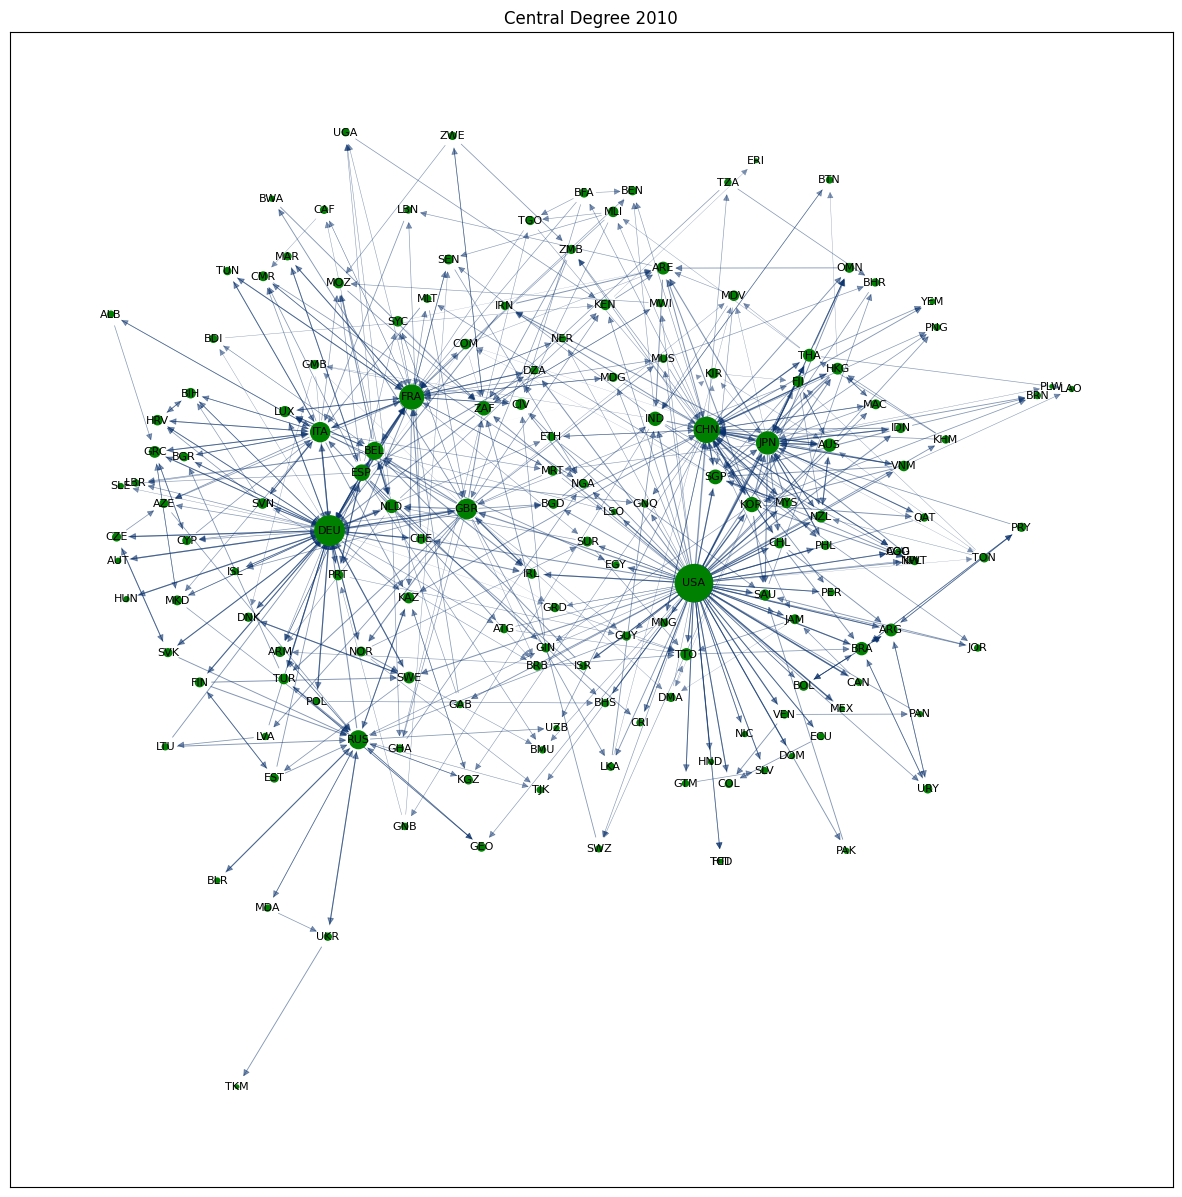

In [18]:
edges = G2010bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [deg_centr[i]*1000 for i in deg_centr]

# draw the graph
pos = nx.kamada_kawai_layout(G2010bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2010bin, pos, node_size=node_size, node_color='green', label=True)
nx.draw_networkx_edges(G2010bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2010bin, pos, font_size = 8)

plt.title('Central Degree 2010')

plt.savefig("CentralDegree2010.png")
plt.show()

## Betweeness

In [19]:
betweenesCentrality = nx.betweenness_centrality(G2010bin, weight='weight')
sort_orders = sorted(betweenesCentrality.items(), key=lambda x: x[1], reverse=True)

avg_degree_betweenesCentrality = sum(betweenesCentrality.values()) / len(betweenesCentrality)
print('average of bewteenness centrality: {}'.format(avg_degree_betweenesCentrality))
print("10 most important nodes for Betweennes Centrality:")
print('max of betweenes centrality: {}'.format(sort_orders[0]))
for i in range(10):
  print(sort_orders[i])

average of bewteenness centrality: 0.011520225399429665
10 most important nodes for Betweennes Centrality:
max of betweenes centrality: ('USA', 0.41603014733747085)
('USA', 0.41603014733747085)
('DEU', 0.2628631308702297)
('CHN', 0.1322484381180333)
('FRA', 0.1264639465468759)
('GBR', 0.07877307236656708)
('RUS', 0.07408388837816211)
('JPN', 0.06132064524692765)
('ITA', 0.04590495353887908)
('ZAF', 0.03890550123046653)
('IND', 0.028987937688478127)


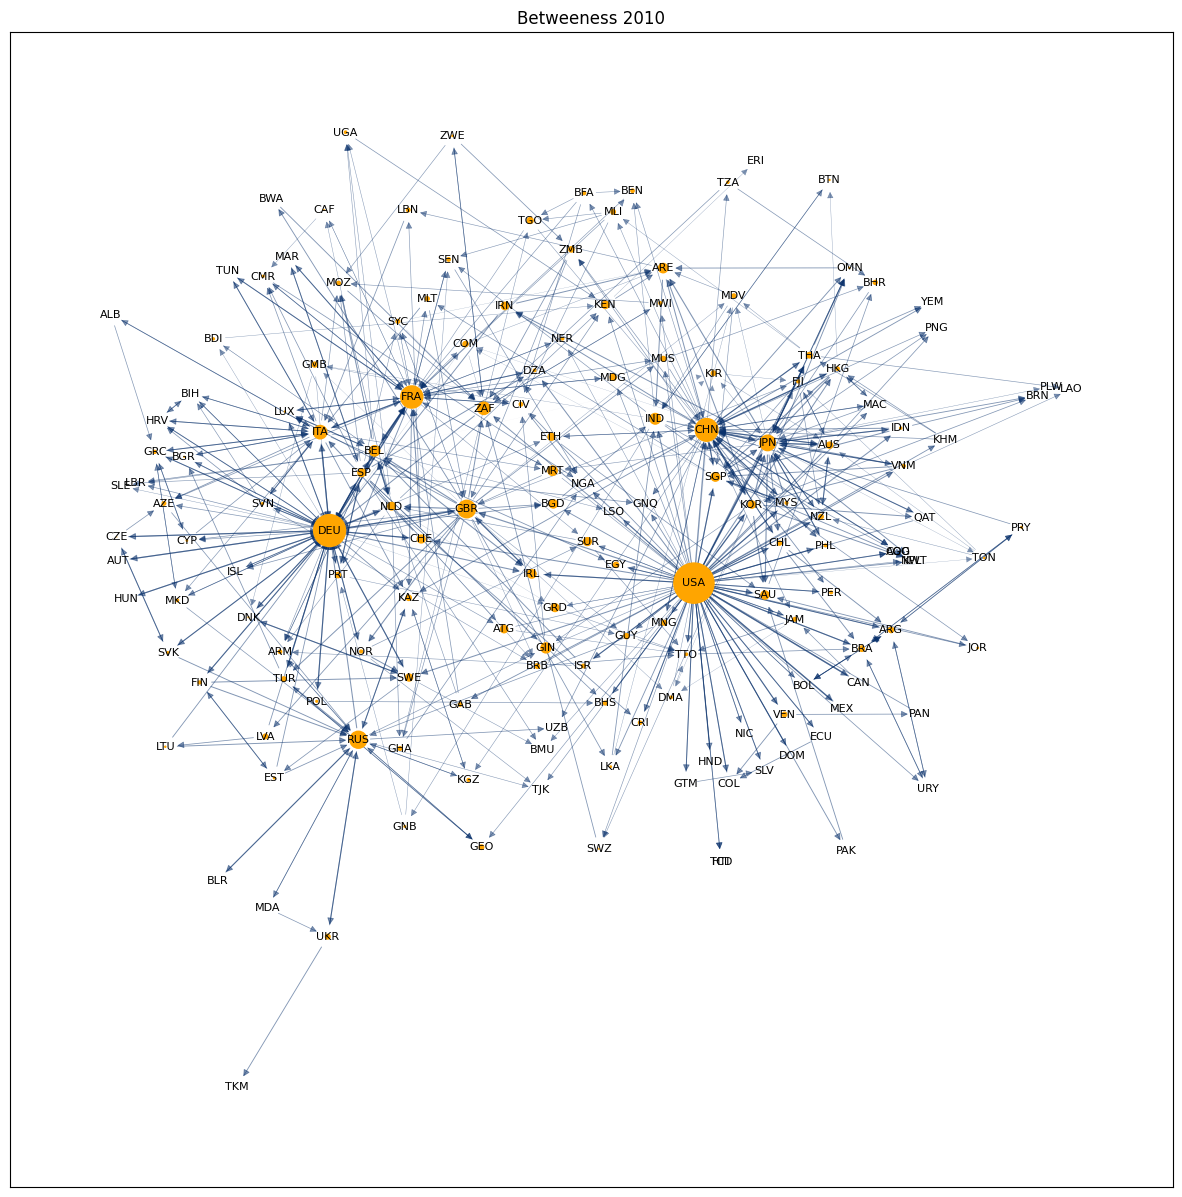

In [20]:
edges = G2010bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [betweenesCentrality[i]*2010 for i in betweenesCentrality]

# draw the graph
pos = nx.kamada_kawai_layout(G2010bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2010bin, pos, node_size=node_size, node_color='orange', label=True)
nx.draw_networkx_edges(G2010bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2010bin, pos, font_size = 8)
plt.title('Betweeness 2010')

plt.savefig("betweeness2010.png")
plt.show()

## Eigenvector

In [21]:
eigen = nx.eigenvector_centrality(G2010bin, weight='weight')
sort_orders = sorted(eigen.items(), key=lambda x: x[1], reverse=True)

avg_degree_eignCentrality = sum(eigen.values()) / len(eigen)
print('average of eignvector centrality: {}'.format(avg_degree_eignCentrality))
print('max of eigenvector centrality: {}'.format(sort_orders[0]))
print("10 most important nodes for Eigenvector Centrality:")
for i in range(10):
  print(sort_orders[i])

average of eignvector centrality: 0.06397688385425634
max of eigenvector centrality: ('USA', 0.3438619465305848)
10 most important nodes for Eigenvector Centrality:
('USA', 0.3438619465305848)
('CHN', 0.2820723966163964)
('DEU', 0.24876721047412378)
('JPN', 0.24035877089123667)
('FRA', 0.20066317006227025)
('SGP', 0.13679952050248778)
('KAZ', 0.12243229163610055)
('ITA', 0.11854199624352986)
('BEL', 0.11440700512313785)
('THA', 0.11188669585806343)


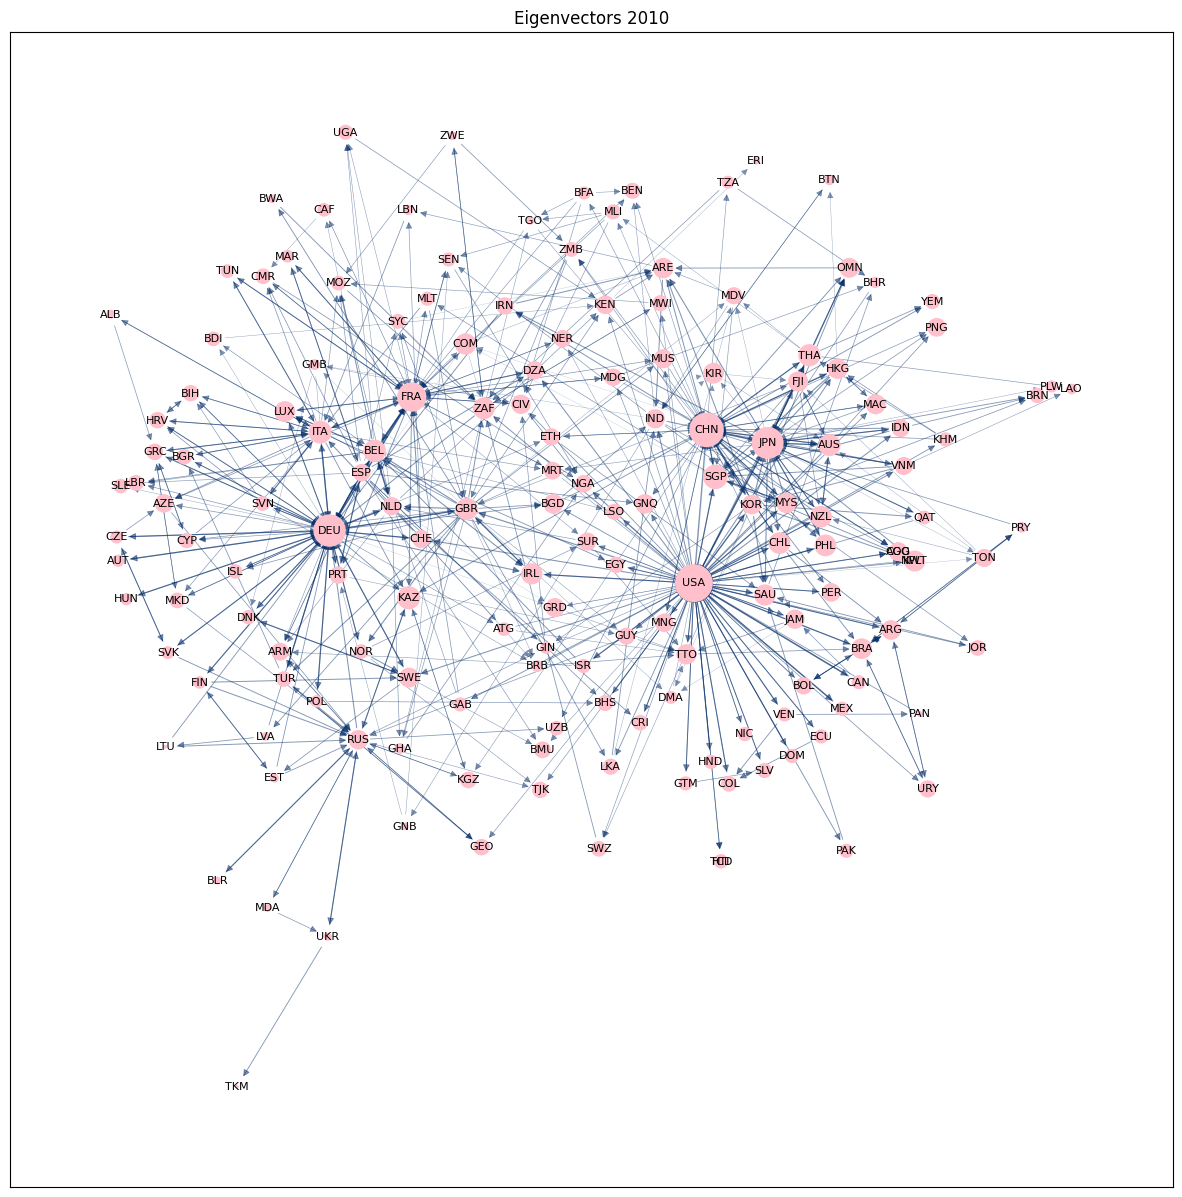

In [22]:
edges = G2010bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [eigen[i]*2010 for i in eigen]

# draw the graph
pos = nx.kamada_kawai_layout(G2010bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2010bin, pos, node_size=node_size, node_color='pink', label=True)
nx.draw_networkx_edges(G2010bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2010bin, pos, font_size = 8)
plt.title('Eigenvectors 2010')

plt.savefig("Eigenvector2010.png")
plt.show()

## Pagerank

In [23]:
pagerank = nx.pagerank(G2010bin, alpha=0.85, weight='weight')
sort_orders = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)


avg_degree_pagerank = sum(pagerank.values()) / len(pagerank)
print('average of pagerank : {}'.format(avg_degree_pagerank))
print('max of pagerank: {}'.format(sort_orders[0]))
print("10 most important nodes for Page Rank:")
for i in range(10):
  print(sort_orders[i])

average of pagerank : 0.0062111801242236
max of pagerank: ('USA', 0.07125292840850879)
10 most important nodes for Page Rank:
('USA', 0.07125292840850879)
('DEU', 0.04794348664652255)
('RUS', 0.03795242044148051)
('FRA', 0.037388898978635086)
('CHN', 0.028981296559813866)
('JPN', 0.02334548330630998)
('ITA', 0.022962857411757926)
('ZAF', 0.020553135963852793)
('BRA', 0.01709145691672423)
('KAZ', 0.013229072199899826)


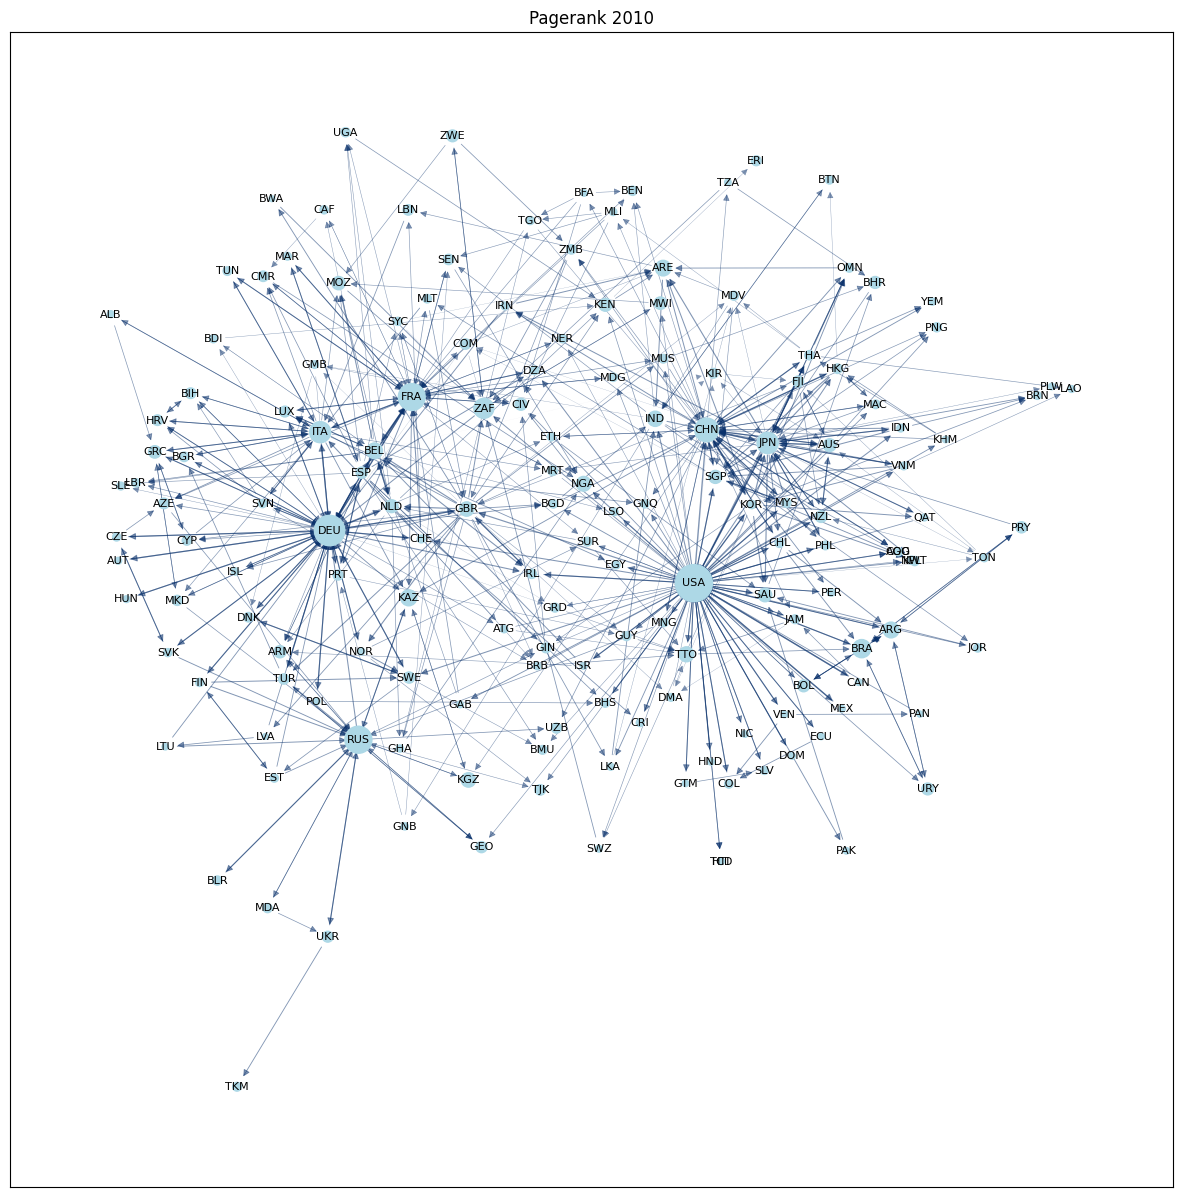

In [24]:
edges = G2010bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [pagerank[i]*10000 for i in pagerank]

# draw the graph
pos = nx.kamada_kawai_layout(G2010bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2010bin, pos, node_size=node_size, node_color='lightblue', label=True)
nx.draw_networkx_edges(G2010bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2010bin, pos, font_size = 8)
plt.title('Pagerank 2010')

plt.savefig("Pagerank2010.png")
plt.show()

## Closeness

In [25]:
closeness = nx.closeness_centrality(G2010bin)
sort_orders = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

avg_degree_closeness = sum(closeness.values()) / len(closeness)
print('average of closeness : {}'.format(avg_degree_closeness))

print("10 most important nodes for closeness_centrality:")
for i in range(10):
  print(sort_orders[i])

average of closeness : 0.28422565978406733
10 most important nodes for closeness_centrality:
('DEU', 0.38580271565495206)
('USA', 0.3809345425867508)
('KAZ', 0.3648225075528701)
('FRA', 0.36046641791044776)
('CHN', 0.35832715133531157)
('GBR', 0.35832715133531157)
('IRL', 0.35001811594202903)
('BGD', 0.3480007204610951)
('COM', 0.34501785714285715)
('SWE', 0.34501785714285715)


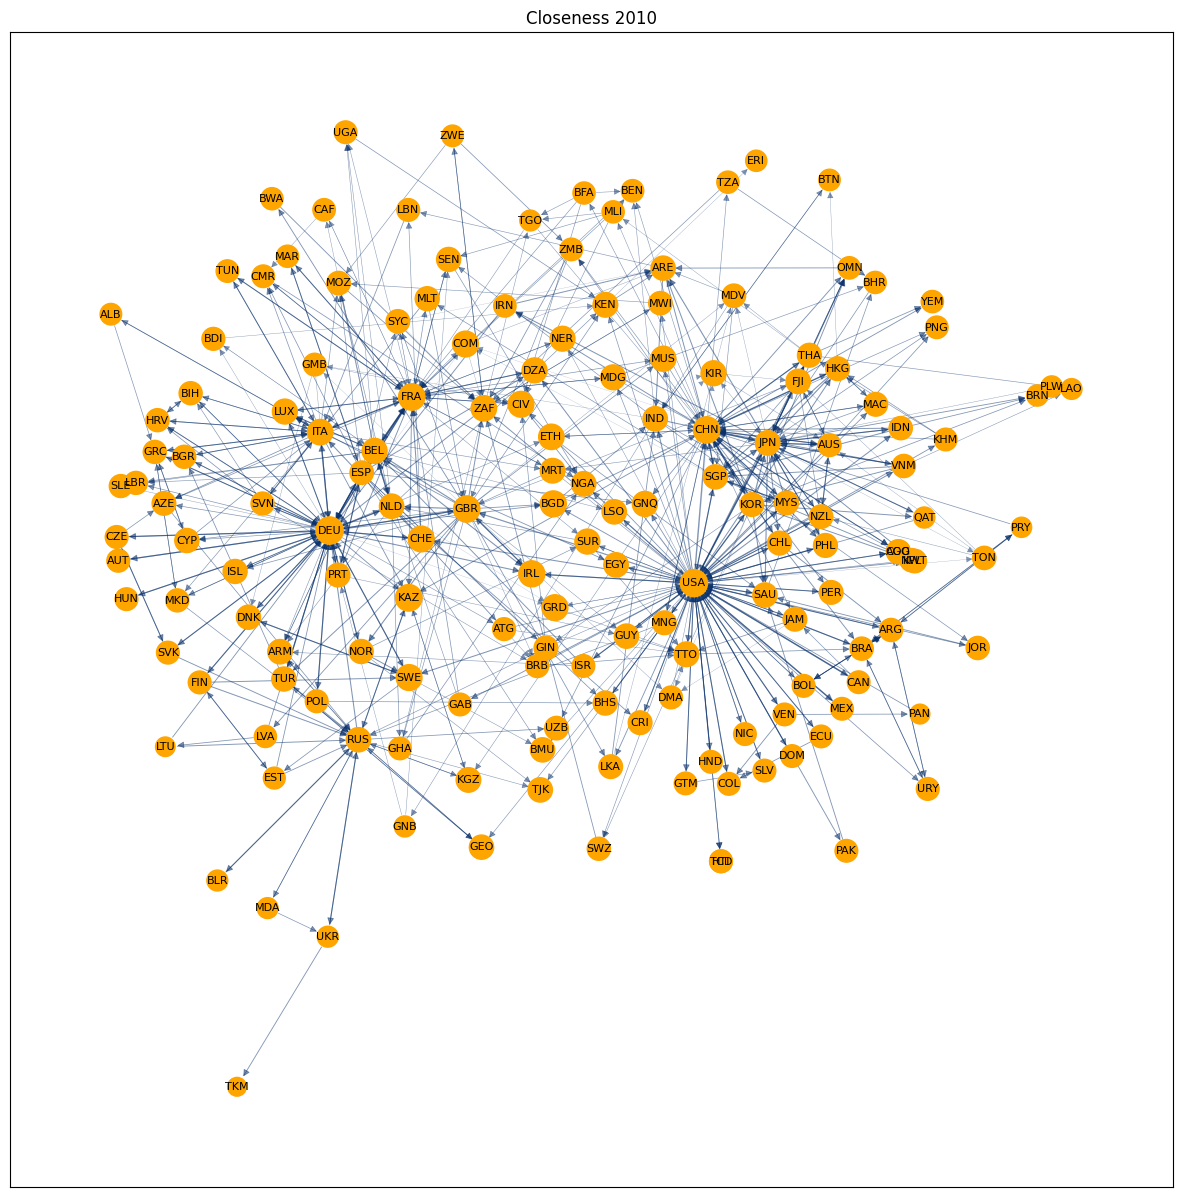

In [26]:
edges = G2010bin.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
node_size = [closeness[i]*1000 for i in closeness]

# draw the graph
pos = nx.kamada_kawai_layout(G2010bin)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G2010bin, pos, node_size=node_size, node_color='orange', label=True)
nx.draw_networkx_edges(G2010bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2010bin, pos, font_size = 8)
plt.title('Closeness 2010')

plt.savefig("closeness2010.png")
plt.show()

## Communities

In [27]:
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

list_community_sets_greedy = list(nx_comm.greedy_modularity_communities(G2010bin,weight='weight'))
print(list_community_sets_greedy[0:20])

[frozenset({'SVK', 'MKD', 'MDA', 'AUT', 'CZE', 'SVN', 'HUN', 'EST', 'CYP', 'LTU', 'UKR', 'KGZ', 'POL', 'AZE', 'ITA', 'SWE', 'BIH', 'GEO', 'ISL', 'TUR', 'RUS', 'NOR', 'BLR', 'LBN', 'ALB', 'GRC', 'DNK', 'LVA', 'UZB', 'FIN', 'DEU', 'TKM', 'TJK', 'CHE', 'BGR', 'HRV', 'KAZ'}), frozenset({'CAN', 'ATG', 'TCD', 'GUY', 'TTO', 'HND', 'USA', 'DOM', 'SLV', 'GTM', 'AGO', 'GRD', 'BHS', 'BOL', 'PAN', 'VEN', 'NIC', 'URY', 'COG', 'HTI', 'BRB', 'SUR', 'COL', 'CRI', 'MEX', 'CHL', 'PAK', 'DMA', 'PER', 'EGY', 'ARG', 'BRA', 'ECU', 'JAM', 'PRY'}), frozenset({'PNG', 'HKG', 'SGP', 'YEM', 'BRN', 'QAT', 'KOR', 'NZL', 'VNM', 'SAU', 'MAC', 'OMN', 'MDV', 'ETH', 'KIR', 'IRN', 'FJI', 'PHL', 'AUS', 'TON', 'JPN', 'BHR', 'ARE', 'CHN', 'LAO', 'MYS', 'PLW', 'IDN', 'MNG', 'KWT', 'THA', 'COM', 'KHM', 'TZA'}), frozenset({'SWZ', 'BDI', 'UGA', 'BWA', 'IRL', 'MUS', 'ERI', 'GBR', 'SLE', 'GHA', 'LUX', 'MOZ', 'LSO', 'BEL', 'NLD', 'MLT', 'ISR', 'MWI', 'GAB', 'ZWE', 'KEN', 'ZMB', 'LBR', 'ZAF', 'ARM'}), frozenset({'NER', 'BMU', 'SYC'

In [28]:
partition_greedy = {}
for i, comm in enumerate(list_community_sets_greedy):
    print("Community:", i)
    print("Number of elems",len(comm))
    for n in comm:
        partition_greedy[n]=i

Community: 0
Number of elems 37
Community: 1
Number of elems 35
Community: 2
Number of elems 34
Community: 3
Number of elems 25
Community: 4
Number of elems 23
Community: 5
Number of elems 7


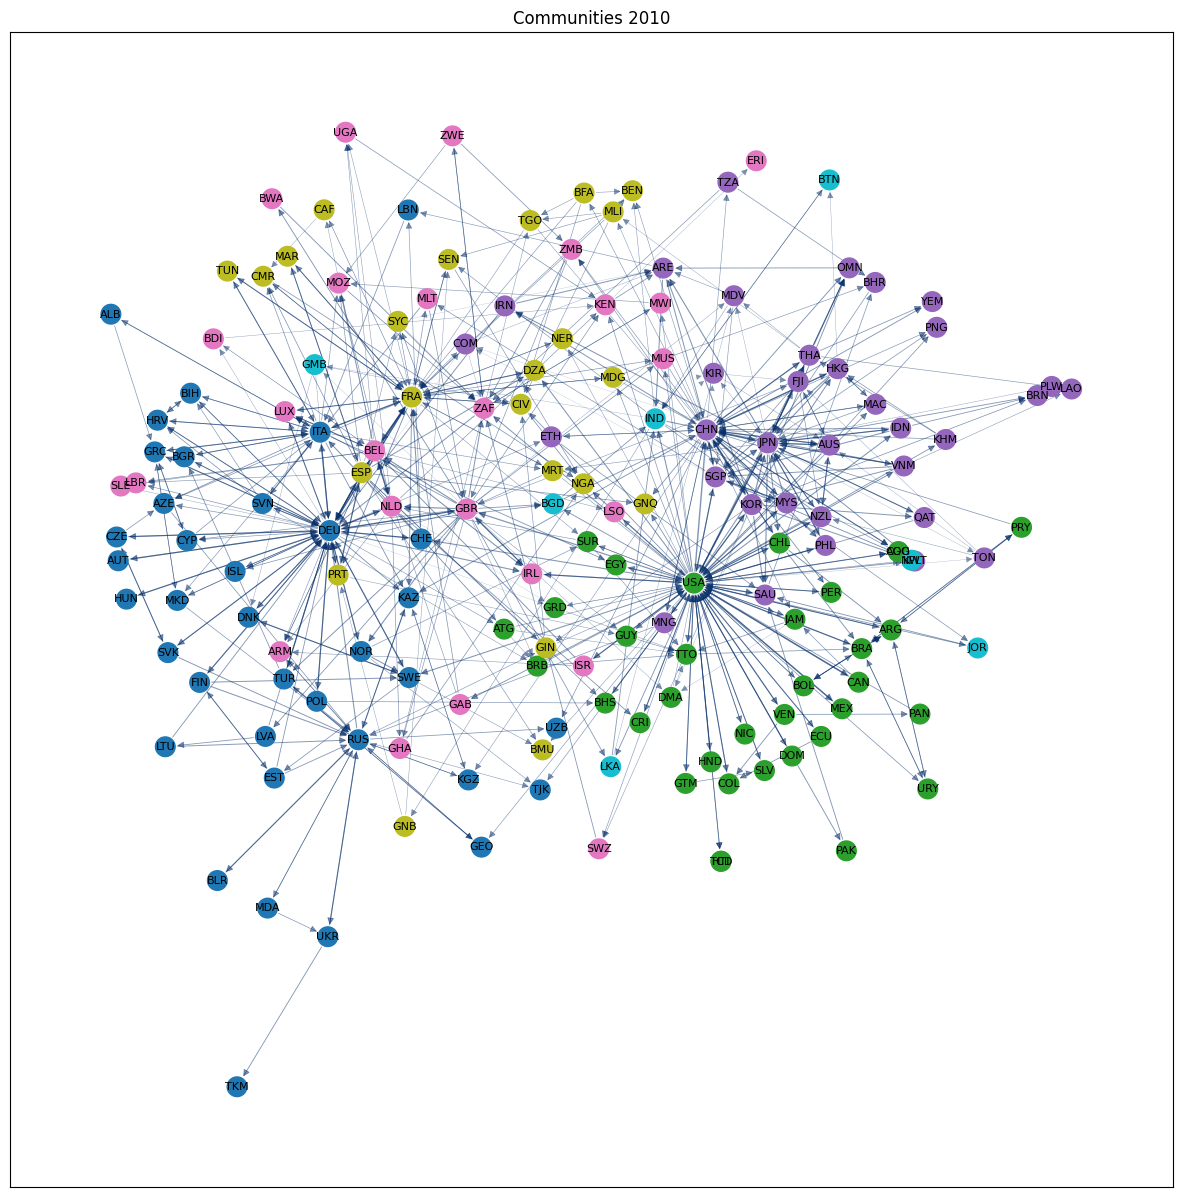

In [29]:
# draw the graph
pos = nx.kamada_kawai_layout(G2010bin)
# color the nodes according to their partition
cmap = cm.get_cmap('tab10', max(partition_greedy.values()) + 1)
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G2010bin, pos, partition_greedy.keys(), node_size=200,
                       cmap=cmap, node_color=list(partition_greedy.values()))
nx.draw_networkx_edges(G2010bin, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)
nx.draw_networkx_labels(G2010bin, pos, font_size = 8)
plt.title('Communities 2010')
plt.savefig('Commmunity2010.png')


plt.show()

# Analysis on original graph

## Density

In [30]:
density = nx.density(G2010)
print('Density 2010: {}'.format(density))

Density 2010: 0.6677406832298136


## Degree

In [31]:
degree = list(dict(G2010.degree()).values())
print('Standard deviation: {}'.format(np.std(degree)))
print('Mean: {}'.format(np.mean(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))
print("Assortativity coefficient: " + str(nx.degree_assortativity_coefficient(G2010)))

Standard deviation: 71.77843778072834
Mean: 213.67701863354037
Median: 228.0
Min: 23
Max: 300
Assortativity coefficient: -0.22299489791267904


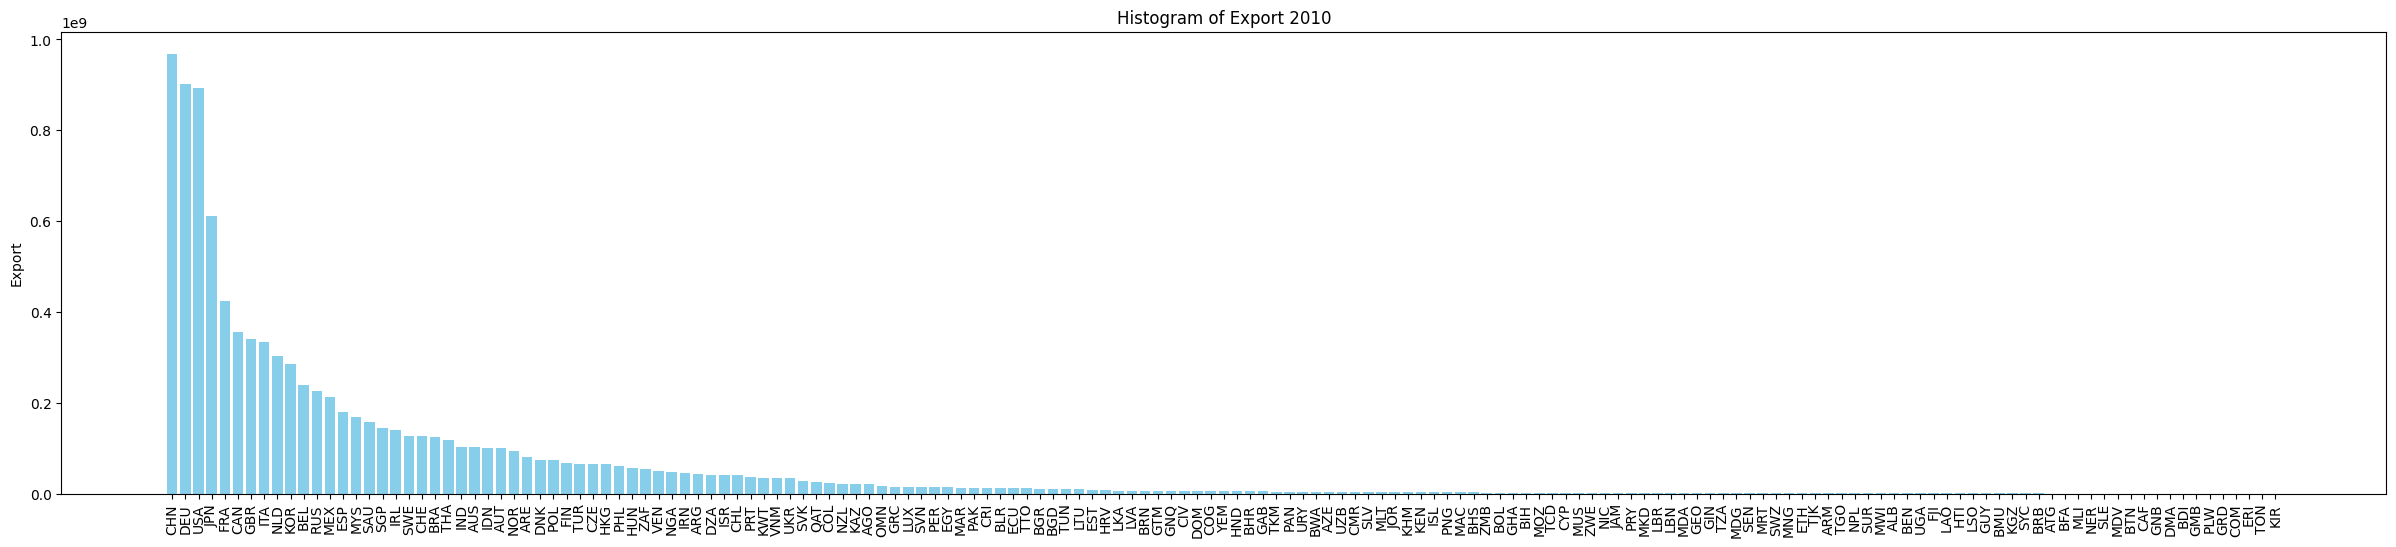

In [32]:
plot = 'Export'
plt.figure(figsize=(30, 6))
plt.bar(df_2010.sort_values(by=plot, ascending=False)['index'], df_2010.sort_values(by=plot, ascending=False)[plot], color='skyblue')
plt.ylabel(plot)
plt.title('Histogram of '+plot+' 2010')
plt.xticks(rotation=90)
plt.savefig(plot+"2010.png")
plt.show()


In [33]:
print(list(nx.isolates(G2010)))

[]


## Clustering

In [34]:
clusters = nx.average_clustering(G2010) #weight='price'
clusters

0.8398366115738629

In [35]:
local_cluster = nx.clustering(G2010, weight='price')
sorted(local_cluster.items(), key=lambda item: item[1], reverse= True)


[('USA', 0.003039373865286061),
 ('DEU', 0.0025979414513849957),
 ('CHN', 0.0021884972871977952),
 ('JPN', 0.001774021730313583),
 ('FRA', 0.001757438297176281),
 ('GBR', 0.0017200414203662861),
 ('ITA', 0.001494358471376248),
 ('NLD', 0.00128276456042021),
 ('BEL', 0.0012071212153364225),
 ('KOR', 0.001131383473305571),
 ('ESP', 0.0011095529364853478),
 ('SGP', 0.0010052480584647585),
 ('RUS', 0.0008828717420558737),
 ('CAN', 0.0008700898906424254),
 ('SWE', 0.0007237848330170495),
 ('CHE', 0.0007199528248905407),
 ('SAU', 0.0006829656439234354),
 ('BRA', 0.0006585177976533722),
 ('THA', 0.0006537567982771661),
 ('HKG', 0.0006529972191638254),
 ('IND', 0.0006521268447309457),
 ('MYS', 0.0006500773856413679),
 ('TUR', 0.0006265361350597675),
 ('MEX', 0.0006233574081824867),
 ('AUS', 0.0006052187704645213),
 ('AUT', 0.0005957954479546026),
 ('IRL', 0.0005517378509007098),
 ('POL', 0.0005430358796433636),
 ('FIN', 0.0005016405471749586),
 ('DNK', 0.000501537925561551),
 ('IDN', 0.0004947

## Centrality

In [36]:
import statistics
deg_centr = nx.degree_centrality(G2010)
sort_orders = sorted(deg_centr.items(), key=lambda x: x[1], reverse=True)
avg_degree_centrality = sum(deg_centr.values()) / len(deg_centr)
print('average of degree centrality: {}'.format(avg_degree_centrality))

degree_centrality_values = list(deg_centr.values())
median_degree_centrality = statistics.median(degree_centrality_values)
print('median of degree centrality: {}'.format(median_degree_centrality))
print('min of degree centrality: {}'.format(sort_orders[-1]))
print('max of degree centrality: {}'.format(sort_orders[0]))

print("10 most important nodes for Degree Centrality:")
for i in range(10):
  print(sort_orders[i])

average of degree centrality: 1.335481366459628
median of degree centrality: 1.425
min of degree centrality: ('PLW', 0.14375000000000002)
max of degree centrality: ('DEU', 1.875)
10 most important nodes for Degree Centrality:
('DEU', 1.875)
('GBR', 1.8687500000000001)
('ITA', 1.8687500000000001)
('JPN', 1.8687500000000001)
('USA', 1.8687500000000001)
('MYS', 1.8625)
('CHN', 1.8562500000000002)
('FRA', 1.8562500000000002)
('IND', 1.8562500000000002)
('AUS', 1.85)


## Betweeness

In [37]:
betweenesCentrality = nx.betweenness_centrality(G2010, weight='price')
sort_orders = sorted(betweenesCentrality.items(), key=lambda x: x[1], reverse=True)

avg_degree_betweenesCentrality = sum(betweenesCentrality.values()) / len(betweenesCentrality)
print('average of bewteenness centrality: {}'.format(avg_degree_betweenesCentrality))
print("10 most important nodes for Betweennes Centrality:")
print('max of betweenes centrality: {}'.format(sort_orders[0]))
for i in range(10):
  print(sort_orders[i])

average of bewteenness centrality: 0.022701448298761664
10 most important nodes for Betweennes Centrality:
max of betweenes centrality: ('NIC', 0.1895440251572327)
('NIC', 0.1895440251572327)
('UGA', 0.16898584905660377)
('ATG', 0.16132075471698112)
('YEM', 0.15169025157232705)
('BRB', 0.14437893081761005)
('BWA', 0.13579009433962264)
('CIV', 0.11595911949685533)
('DOM', 0.11401336477987421)
('CYP', 0.11053459119496854)
('ZWE', 0.10941430817610062)


## Eigenvector

In [38]:
eigen = nx.eigenvector_centrality(G2010, weight='price')
sort_orders = sorted(eigen.items(), key=lambda x: x[1], reverse=True)

avg_degree_eignCentrality = sum(eigen.values()) / len(eigen)
print('average of eignvector centrality: {}'.format(avg_degree_eignCentrality))
print('max of eigenvector centrality: {}'.format(sort_orders[0]))
print("10 most important nodes for Eigenvector Centrality:")
for i in range(10):
  print(sort_orders[i])

average of eignvector centrality: 0.02883151883210447
max of eigenvector centrality: ('CHN', 0.5098459628520773)
10 most important nodes for Eigenvector Centrality:
('CHN', 0.5098459628520773)
('USA', 0.42691244469972967)
('JPN', 0.36319709208647805)
('CAN', 0.3251826427915546)
('DEU', 0.2943916103739065)
('KOR', 0.19246346028940264)
('MEX', 0.19188998825478254)
('FRA', 0.158027519197231)
('GBR', 0.14570645514031447)
('ITA', 0.12468185261288106)


## Pagerank

In [39]:
pagerank = nx.pagerank(G2010, alpha=0.85, weight='price')
sort_orders = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)


avg_degree_pagerank = sum(pagerank.values()) / len(pagerank)
print('average of pagerank : {}'.format(avg_degree_pagerank))
print('max of pagerank: {}'.format(sort_orders[0]))
print("10 most important nodes for Page Rank:")
for i in range(10):
  print(sort_orders[i])

average of pagerank : 0.006211180124223602
max of pagerank: ('USA', 0.08239619556421264)
10 most important nodes for Page Rank:
('USA', 0.08239619556421264)
('DEU', 0.07393779952699016)
('CHN', 0.0710697773416818)
('JPN', 0.053796649618176894)
('FRA', 0.03820157565274238)
('GBR', 0.03134965428446847)
('ITA', 0.029295725663051355)
('KOR', 0.027336378408804946)
('NLD', 0.024874462822552672)
('RUS', 0.02343658973851966)


## Closeness

In [40]:
closeness = nx.closeness_centrality(G2010)
sort_orders = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

avg_degree_closeness = sum(closeness.values()) / len(closeness)
print('average of closeness : {}'.format(avg_degree_closeness))

print("10 most important nodes for closeness_centrality:")
for i in range(10):
  print(sort_orders[i])

average of closeness : 0.7234801289723973
10 most important nodes for closeness_centrality:
('CHN', 0.875)
('DEU', 0.875)
('FRA', 0.875)
('GBR', 0.875)
('IND', 0.875)
('ITA', 0.875)
('JPN', 0.875)
('BRA', 0.8687943262411347)
('MYS', 0.8687943262411347)
('SGP', 0.8687943262411347)


## Communities

In [41]:
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

list_community_sets_greedy = list(nx_comm.greedy_modularity_communities(G2010,weight='price'))
print(list_community_sets_greedy[0:20])

[frozenset({'SVK', 'CAF', 'AUT', 'GIN', 'SVN', 'HUN', 'SLE', 'EST', 'TGO', 'LTU', 'DZA', 'UKR', 'MLT', 'POL', 'AZE', 'ARM', 'BIH', 'NER', 'BMU', 'NOR', 'BLR', 'ALB', 'GRC', 'DNK', 'LVA', 'EGY', 'NLD', 'BGR', 'PRT', 'TUN', 'KAZ', 'SYC', 'MKD', 'MDA', 'FRA', 'CZE', 'CMR', 'LUX', 'CYP', 'GMB', 'MRT', 'KGZ', 'ITA', 'SWE', 'GEO', 'ISL', 'BDI', 'TUR', 'IRL', 'RUS', 'LBN', 'GBR', 'GHA', 'SEN', 'UZB', 'MAR', 'FIN', 'BEL', 'TKM', 'DEU', 'BFA', 'TJK', 'CIV', 'BEN', 'CHE', 'MLI', 'HRV', 'LBR', 'ESP'}), frozenset({'PNG', 'SWZ', 'IND', 'UGA', 'SGP', 'HKG', 'YEM', 'GNB', 'BRN', 'MUS', 'QAT', 'KOR', 'NZL', 'VNM', 'SAU', 'NPL', 'MAC', 'OMN', 'MDV', 'MOZ', 'ETH', 'KIR', 'IRN', 'MWI', 'FJI', 'BGD', 'PHL', 'AUS', 'TON', 'LKA', 'COG', 'BWA', 'BTN', 'JPN', 'ERI', 'BHR', 'ARE', 'JOR', 'MDG', 'PAK', 'CHN', 'LAO', 'MYS', 'PLW', 'IDN', 'MNG', 'KWT', 'THA', 'COM', 'ZWE', 'KEN', 'ZMB', 'TZA', 'ZAF'}), frozenset({'CAN', 'ATG', 'TCD', 'GUY', 'HND', 'TTO', 'USA', 'DOM', 'SLV', 'GTM', 'LSO', 'AGO', 'GRD', 'BHS', 'GA

In [42]:
partition_greedy = {}
for i, comm in enumerate(list_community_sets_greedy):
    print("Community:", i)
    print("Number of elems",len(comm))
    for n in comm:
        partition_greedy[n]=i

Community: 0
Number of elems 69
Community: 1
Number of elems 54
Community: 2
Number of elems 38


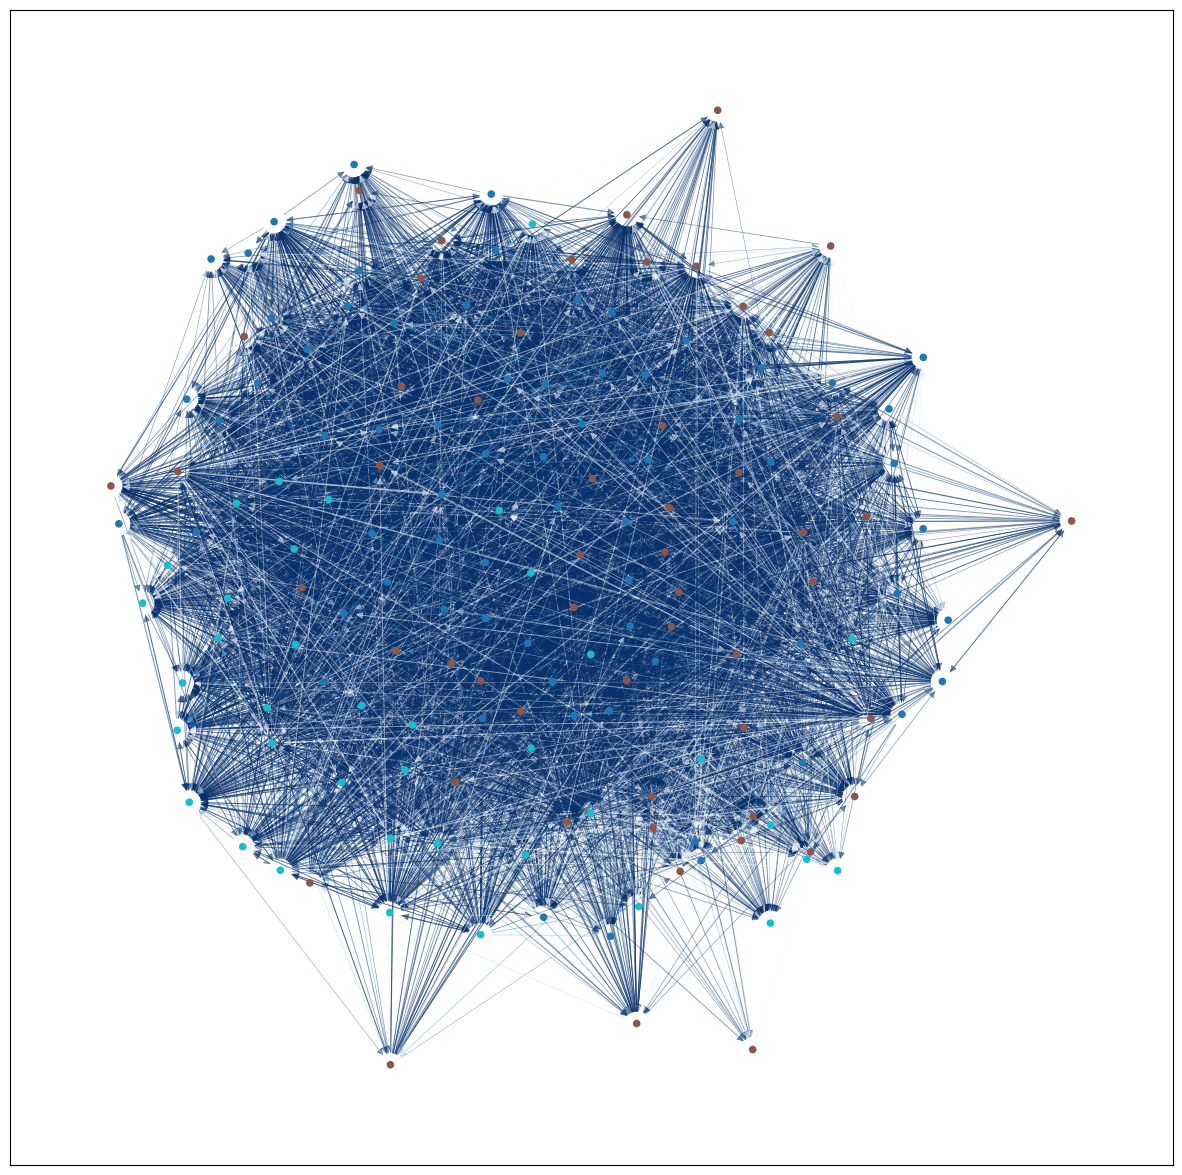

In [43]:
edges = G2010.edges(data=True)
edge_colors = [attr['price'] for _, _, attr in edges]
# draw the graph
pos = nx.kamada_kawai_layout(G2010)
# color the nodes according to their partition
cmap = cm.get_cmap('tab10', max(partition_greedy.values()) + 1)
plt.figure(figsize=(15,15))

nx.draw_networkx_nodes(G2010, pos, partition_greedy.keys(), node_size=20,
                       cmap=cmap, node_color=list(partition_greedy.values()))
nx.draw_networkx_edges(G2010, pos, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, edge_vmin=min_price, edge_vmax=max_price, width=norm_prices)


plt.show()

## Data correlations

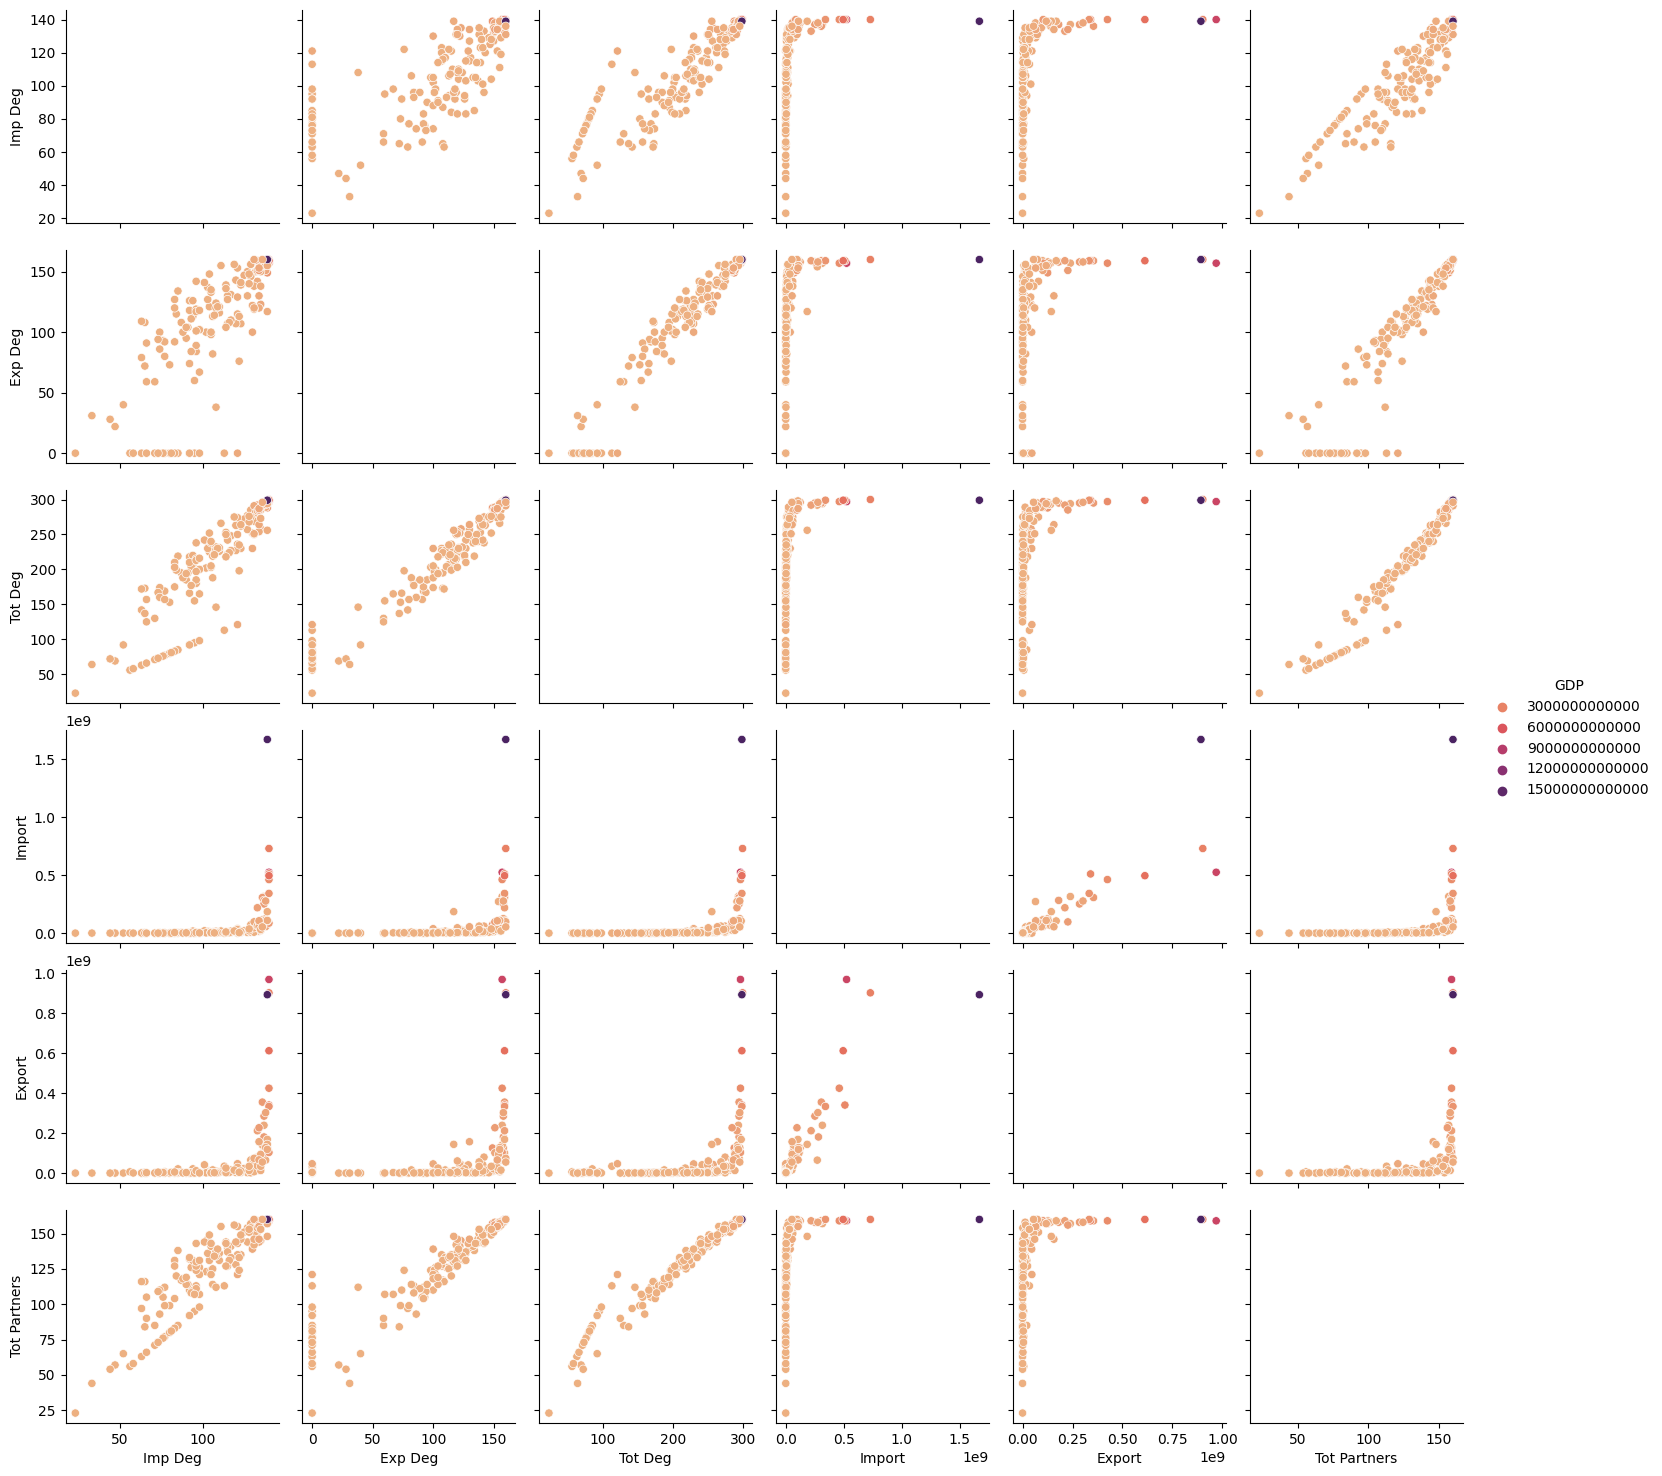

In [44]:
sns.pairplot(df_2010, hue = 'GDP'
             , diag_kind='auto',
             palette='flare'
            )